In [1]:
# MA Cross Backtesting on 1H BTC with following trade costs and timeframes
# - Slippage is 0.5BPS
# - Taker fee is 0.05%
# - Initial capital is 10000.0$
# - Position size per trade is 2% of account
# - Timeframe is 1H
# 

In [2]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import yfinance          as yf
import pandas            as pd
import numpy             as np
import quantstats        as qs
import matplotlib.pyplot as plt

In [3]:
df_ = pd.read_csv("./data/crypto-spot/BTCUSDT.csv", parse_dates=True, index_col=0)
df_.index = pd.to_datetime(df_.index, format='mixed')
df_.index = pd.DatetimeIndex(df_.index)

hours               = 1
timeframe_by_minute = hours*60
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df['Price'] = df['Open'].shift(-1)
df.dropna(inplace=True)

df

,Open,High,Low,Close,Volume,Price
date,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,4308.83
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,4315.32
2017-08-17 06:00:00,4315.32,4345.45,4309.37,4324.35,7.229691,4324.35
2017-08-17 07:00:00,4324.35,4349.99,4287.41,4349.99,4.443249,4333.32
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,4360.69
...,...,...,...,...,...,...
2024-01-31 18:00:00,43715.04,43745.11,43474.13,43513.38,1499.795790,43513.38
2024-01-31 19:00:00,43513.38,43551.99,43041.10,43334.64,2549.594580,43334.63
2024-01-31 20:00:00,43334.63,43361.10,42519.92,42541.18,3928.704250,42541.19


<Axes: xlabel='date'>

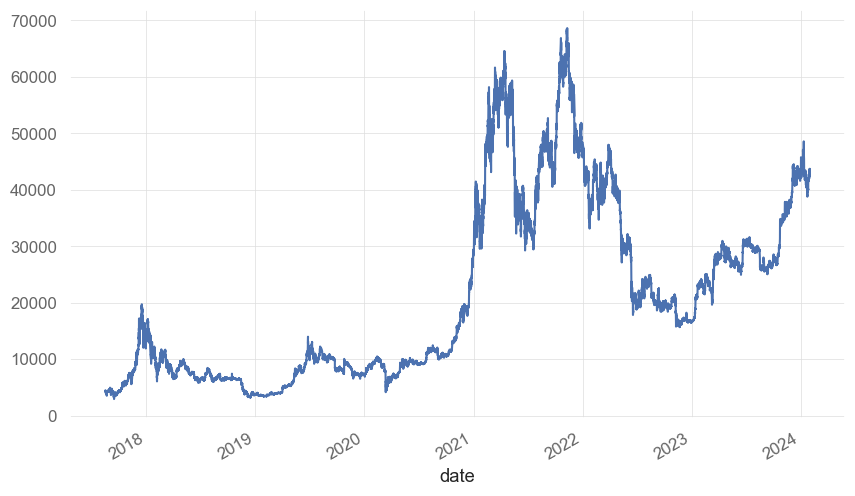

In [4]:
df['Close'].plot()

In [5]:
df.dropna(inplace=True)

In [6]:
# Signal extraction

df['MA50' ] = df['Close'].rolling(window=20).mean()
df['MA200'] = df['Close'].rolling(window=50).mean()

df['Signal'] = 0
df.loc[((df['MA50'] > df['MA200']) & (df['MA50'].shift(1) <= df['MA200'].shift(1))), 'Signal'] =  1
df.loc[((df['MA50'] < df['MA200']) & (df['MA50'].shift(1) >= df['MA200'].shift(1))), 'Signal'] = -1

In [7]:
df['Signal'].value_counts()

Signal
 0    55116
 1      670
-1      670
Name: count, dtype: int64

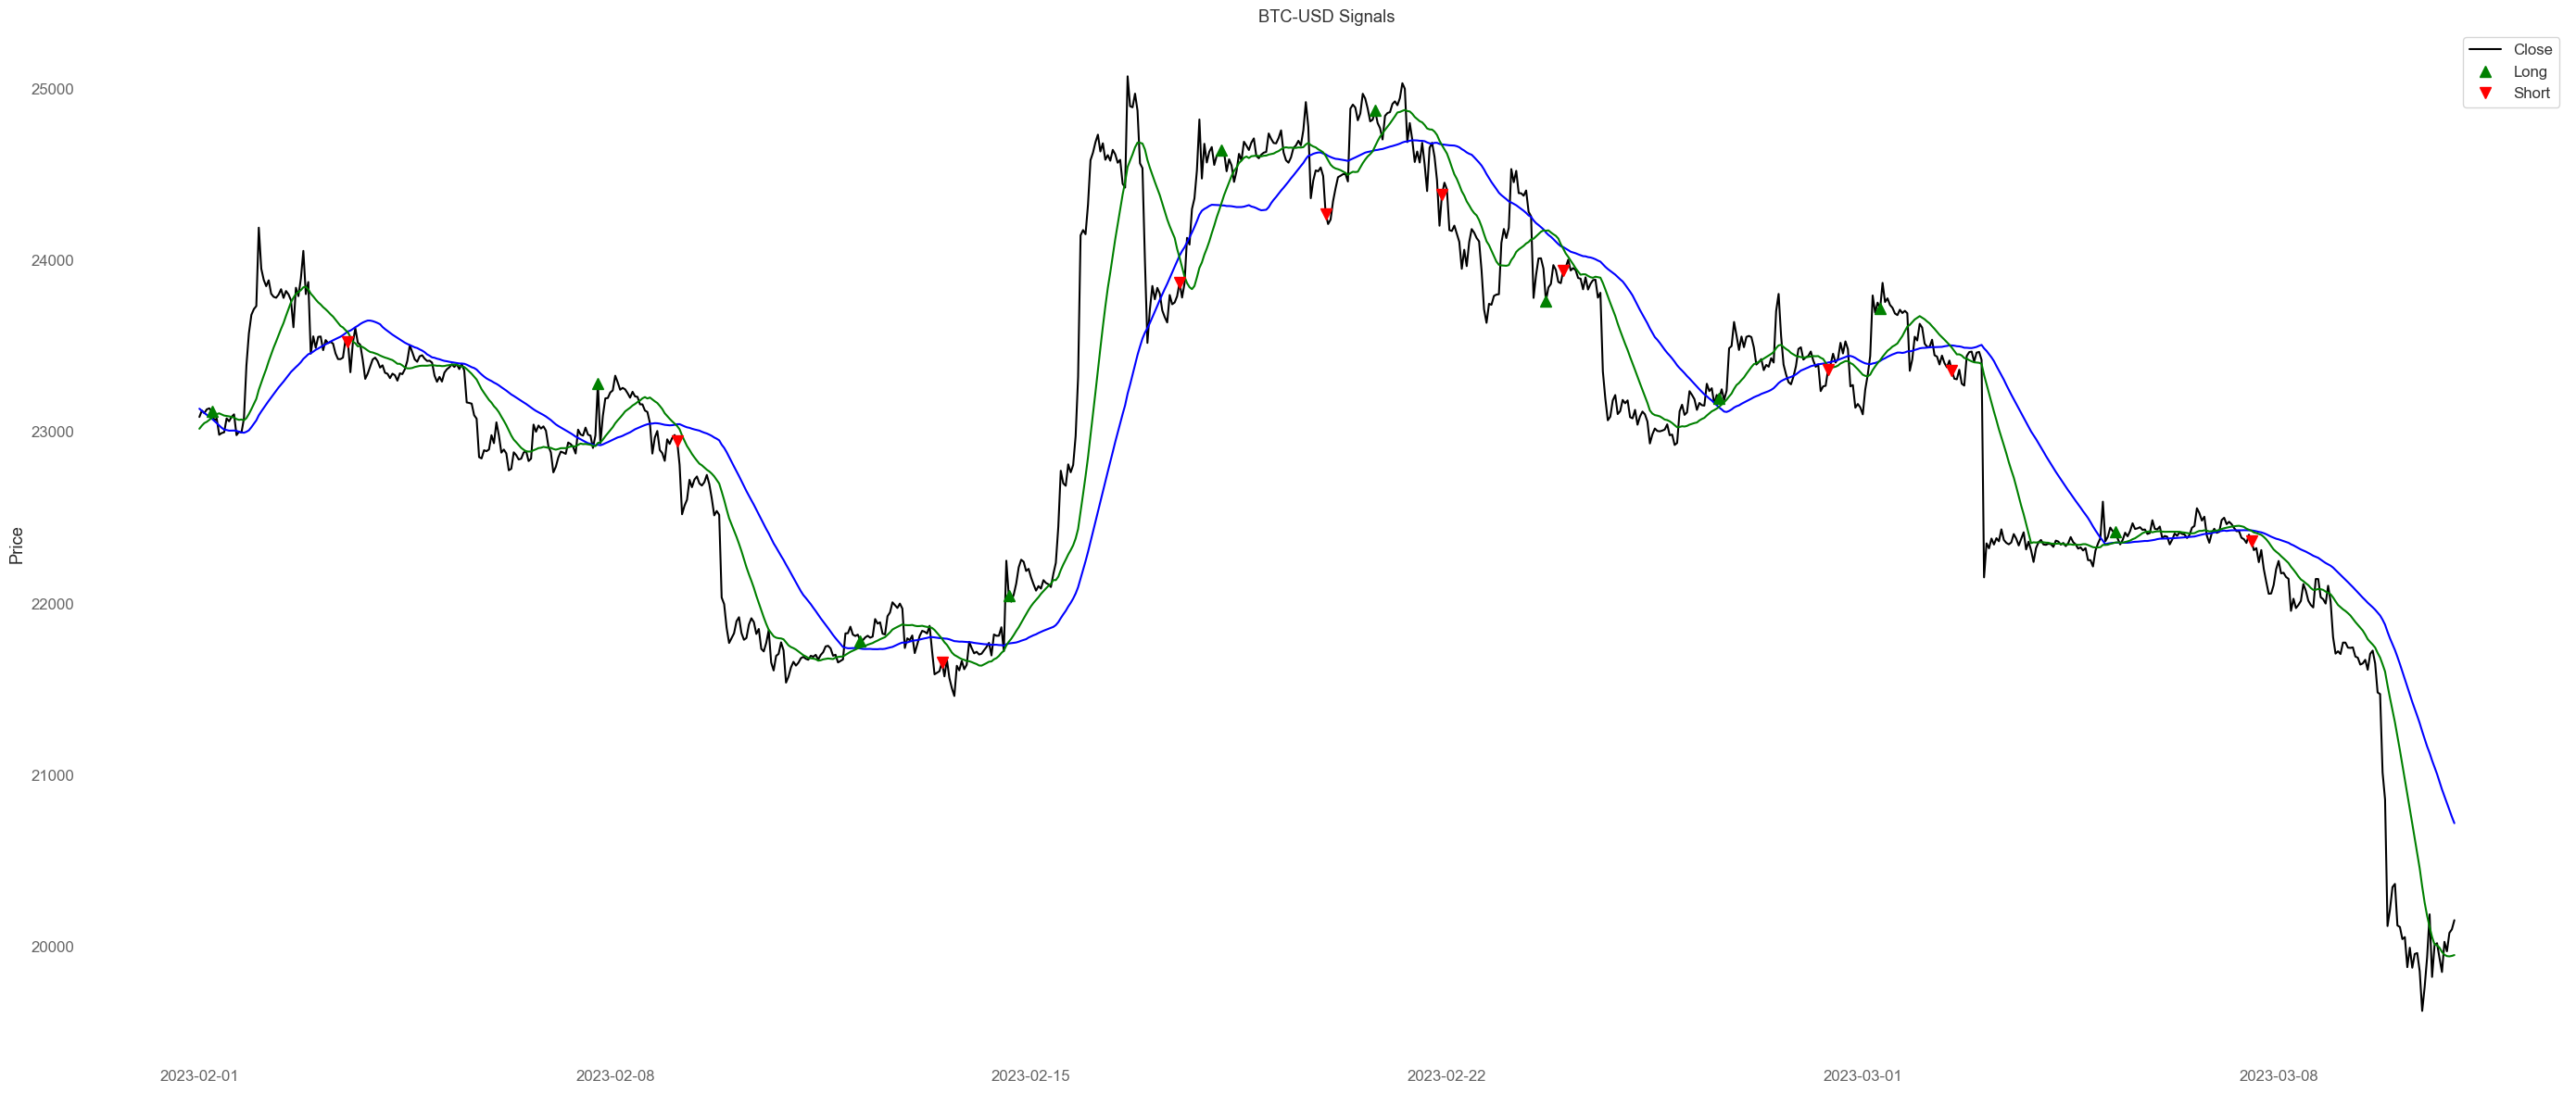

In [8]:
plot_df = df["2023-02-01":"2023-03-10"]

fig, ax1 = plt.subplots(1, figsize=(28, 12), sharex=True)

ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax1.plot(plot_df['MA200'], color='blue' )
ax1.plot(plot_df['MA50' ], color='green')
ax1.plot(plot_df[plot_df['Signal'] ==  1].index, plot_df[plot_df['Signal'] ==  1]['Close'], '^', markersize=8, color='green', label='Long' )
ax1.plot(plot_df[plot_df['Signal'] == -1].index, plot_df[plot_df['Signal'] == -1]['Close'], 'v', markersize=8, color='red'  , label='Short')
ax1.set_ylabel('Price')
ax1.set_title('BTC-USD Signals')
ax1.legend()
ax1.grid()

plt.tight_layout()
plt.show()

In [9]:
# Position tracking
position         = 0
entry_timestamp  = None
entry_price      = 0
exit_timestamp   = None
exit_price       = 0
position_history = []

for index, row in df.iterrows():
    if row['Signal'] != position:
        # Exit position
        if position != 0:
            exit_timestamp = index
            exit_price     = row['Price'] 
            pct_change     = (exit_price - entry_price) / entry_price
            position_history.append((entry_timestamp, exit_timestamp, entry_price, exit_price, pct_change))
        # Enter new position
        if row['Signal'] == 1:
            entry_timestamp = index
            entry_price     = row['Price']
        elif row['Signal'] == -1:
            entry_timestamp = index
            entry_price     = row['Price']
        position = row['Signal']

position_df = pd.DataFrame(position_history, columns=['EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'Return'])
position_df = position_df.set_index(pd.DatetimeIndex(position_df['EntryTime']))

position_df

,EntryTime,ExitTime,EntryPrice,ExitPrice,Return
EntryTime,,,,,
2017-08-20 13:00:00,2017-08-20 13:00:00,2017-08-20 14:00:00,4063.35,4096.32,0.008114
2017-08-21 12:00:00,2017-08-21 12:00:00,2017-08-21 13:00:00,4000.00,3914.59,-0.021352
2017-08-23 03:00:00,2017-08-23 03:00:00,2017-08-23 04:00:00,4084.54,4084.00,-0.000132
2017-08-26 14:00:00,2017-08-26 14:00:00,2017-08-26 15:00:00,4274.00,4275.00,0.000234
2017-08-27 11:00:00,2017-08-27 11:00:00,2017-08-27 12:00:00,4323.37,4314.11,-0.002142
...,...,...,...,...,...
2024-01-26 04:00:00,2024-01-26 04:00:00,2024-01-26 05:00:00,40149.25,40102.40,-0.001167
2024-01-26 11:00:00,2024-01-26 11:00:00,2024-01-26 12:00:00,41289.52,41140.01,-0.003621
2024-01-29 10:00:00,2024-01-29 10:00:00,2024-01-29 11:00:00,42313.18,42246.95,-0.001565


<Axes: xlabel='EntryTime'>

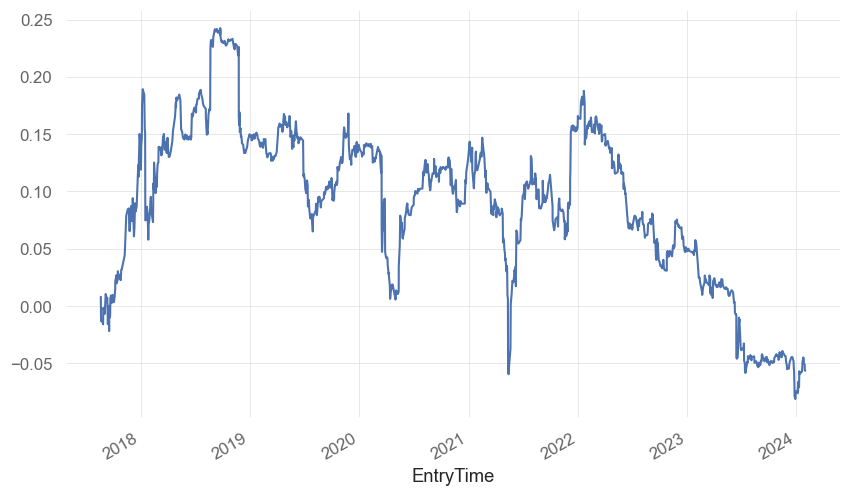

In [10]:
# Naive cumulative sum
position_df['Return'].cumsum().plot()

In [11]:
# Cost adjustments

position_df['LogReturn'] = (1+position_df['Return']).apply(np.log)

slippage_pct  = 0.005 # 0.5BPS 
taker_fee_pct = 0.05  # Binance taker fee is 0.05%
transaction_cost_log = np.log(1-slippage_pct/100.0) + np.log(1-taker_fee_pct/100.0)
position_df['AdjustedLogReturn'] = position_df['LogReturn']  + transaction_cost_log

position_df['CumRet'            ] = 1+position_df['Return'].cumsum()
position_df['CostAdjustedCumRet'] = position_df['AdjustedLogReturn'].cumsum().apply(np.exp)

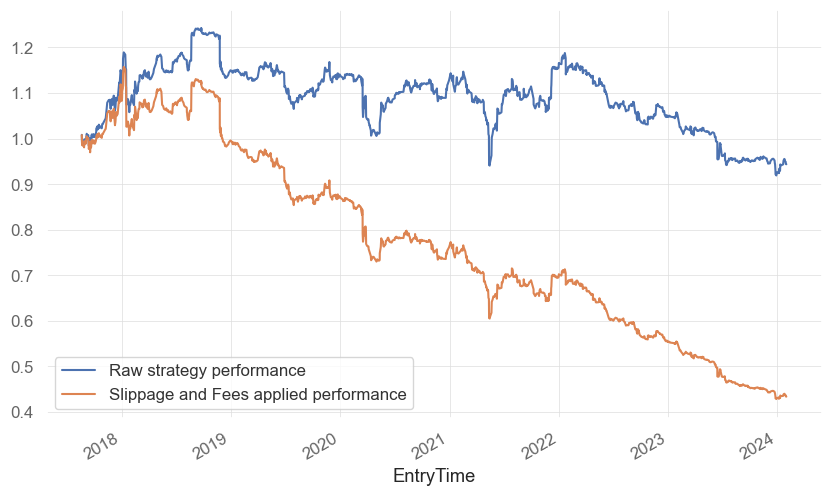

In [12]:
position_df[['CumRet', 'CostAdjustedCumRet']].plot()
plt.legend(['Raw strategy performance', 'Slippage and Fees applied performance'])

In [13]:
position_df['Account Change'] = position_df['CostAdjustedCumRet'].pct_change()

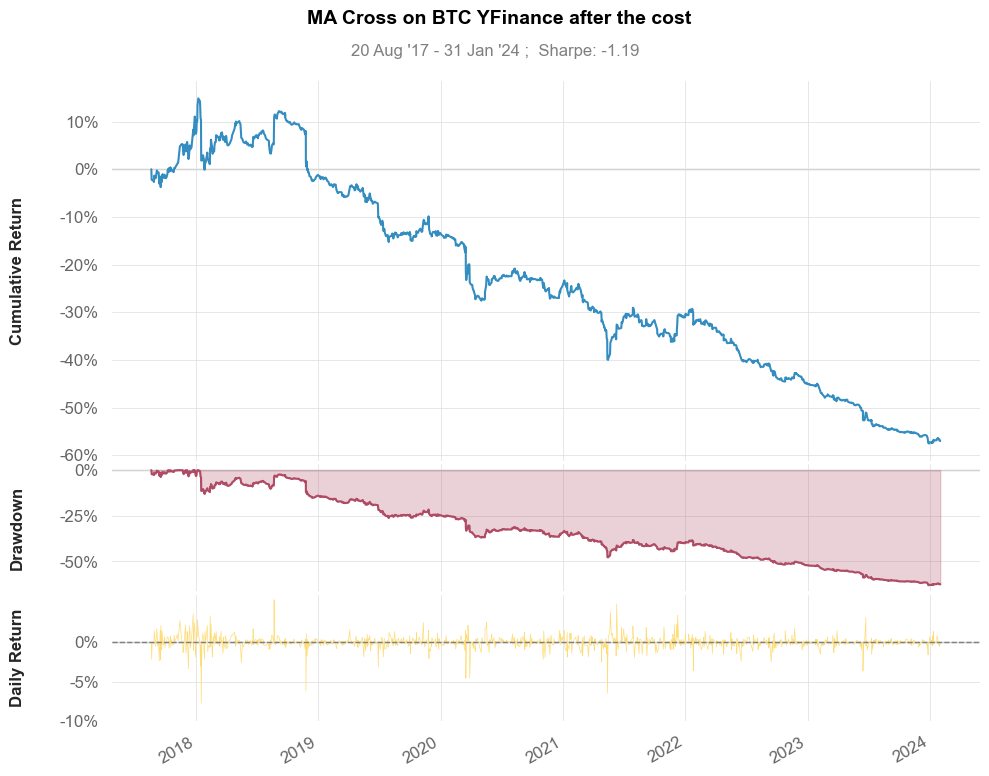

In [14]:
qs.plots.snapshot(position_df['Account Change'], title='MA Cross on BTC YFinance after the cost', show=True);

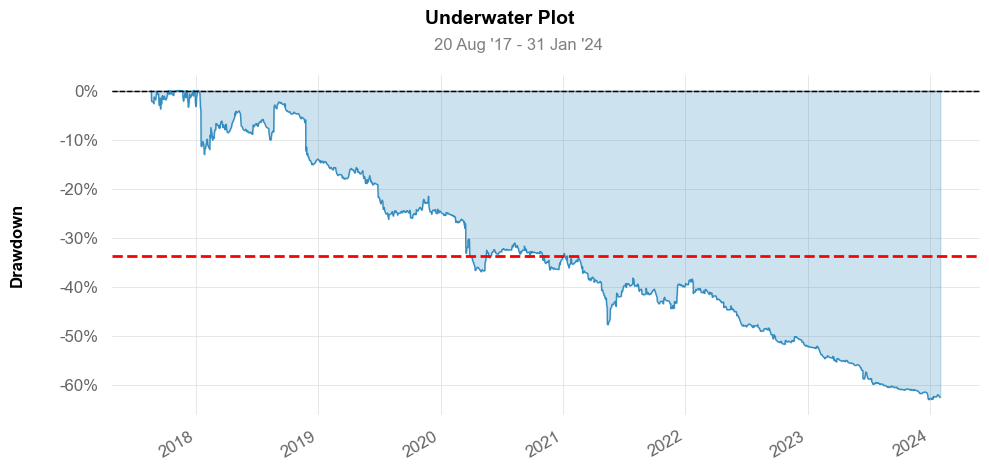

In [15]:
qs.plots.drawdown(position_df['Account Change'])

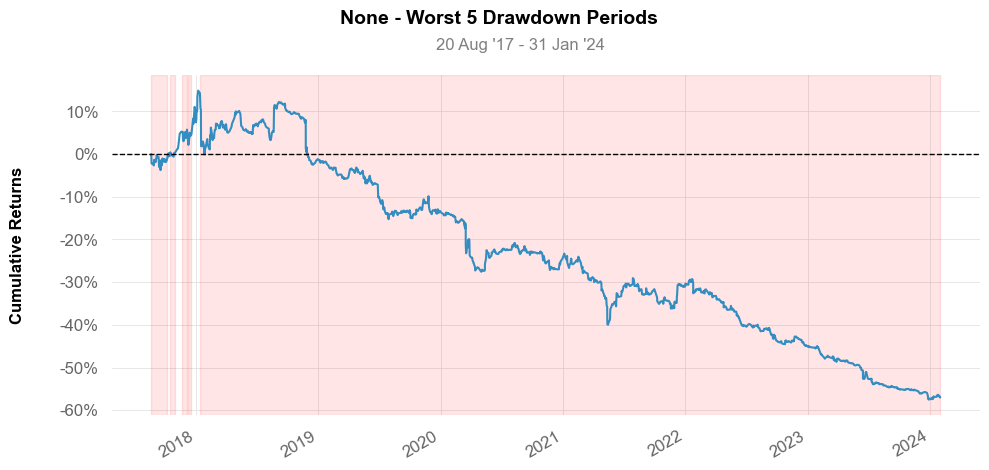

In [16]:
qs.plots.drawdowns_periods(position_df['Account Change'])

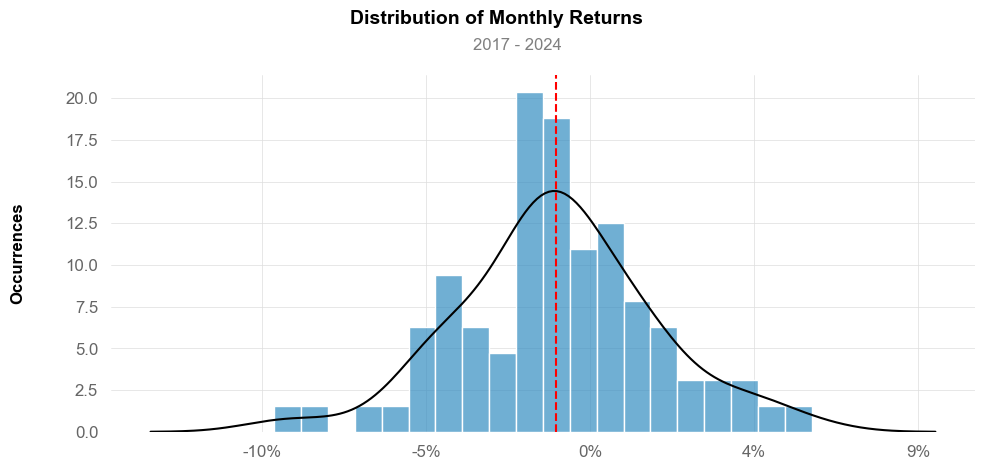

In [17]:
qs.plots.histogram(position_df['Account Change'])

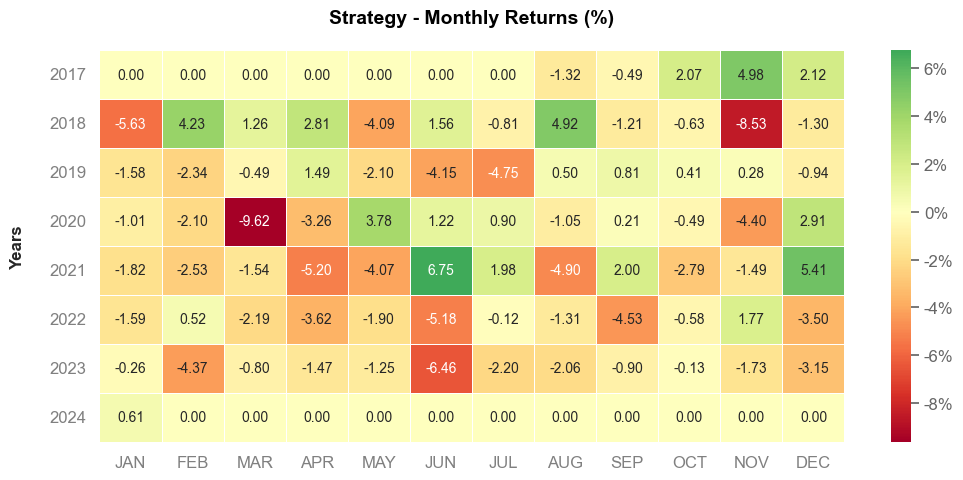

In [18]:
qs.plots.monthly_heatmap(position_df['Account Change'])

In [19]:
qs.stats.sharpe(position_df['Account Change'])

-1.1906109915447676